In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import cartopy.crs as ccrs
import cftime 
import psutil
import xesmf as xe

In [3]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [4]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

In [5]:
mmle_loaded = MultiModelLargeEnsemble('cmip6', 'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario='ssp585',
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/tas.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp585/day/tas.zarr


In [6]:
save_name = f'gcs://{mmle_loaded.bucket}/{mmle_loaded.path}/all_scenarios_x/cmip6.zarr'
mmle_loaded.x = xr.open_zarr(save_name, consolidated=True)[mmle_loaded.variable]

In [7]:
save_name = f'gcs://{mmle_loaded.bucket}/{mmle_loaded.path}/all_scenarios_results/cmip6.zarr'
mmle_loaded.results = xr.open_zarr(save_name, consolidated=True)

In [8]:
mmle_loaded.results.load()

<xarray.Dataset>
Dimensions:    (scenario: 4, time: 130, model: 14, lat: 71, lon: 144)
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    member_id  <U8 'r1i1p1f1'
  * model      (model) <U30 'INM-CM4-8' 'INM-CM5-0' ... 'GFDL-ESM4' 'NorESM2-MM'
    q_values   (model, lat, lon) float64 261.9 261.7 261.5 ... 273.6 273.6 273.6
    quantile   float64 0.9997
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01
Data variables:
    fit        (scenario, time, model, lat, lon) float64 -1.319 ... 285.1
    i_fit      (scenario, model, lat, lon) float64 3.586 2.966 ... 207.9 183.5
    ibar_fit   (scenario, lat, lon) float64 3.664 3.819 ... 2.683e+03 2.751e+03
    m_fit      (scenario, time, lat, lon) float64 8.921 8.731 ... 5.828e+05
    t_fit      (scenario, time, lat, lon) float64 nan nan nan ... nan nan nan

In [9]:
mmle_loaded.x.load()

<xarray.DataArray 'tas' (scenario: 4, model: 14, member_id: 1, time: 130, lat: 71, lon: 144)>
array([[[[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
...
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]]]])
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) <U8 'r1i1p1f1'
  * model      (model) <U30 'INM-CM4-8' 'INM-CM5-0' ... 'GFDL-ESM4' 'NorESM2-MM'
    q_values   (model, lat, lon) float64 261.9 261.7 261.5 ... 273.6 273.6 273.6
    quantile   float64 0.9997
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01

In [11]:
mmle_loaded.results['s_fit'] = mmle_loaded.x.mean('model').var('scenario').isel(member_id=0)

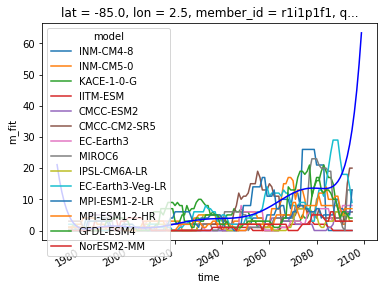

In [12]:
mmle_loaded.x.isel(scenario=1, lat=1, lon=1).plot(hue='model')
mmle_loaded.results['m_fit'].isel(scenario=1, lat=1, lon=1).plot(color='blue')


In [13]:
mmle_loaded.results['t_fit'] = mmle_loaded.results['m_fit'].mean('scenario')+ mmle_loaded.results['ibar_fit'].mean('scenario') + mmle_loaded.results['s_fit']

In [14]:
import dask
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

In [15]:
mmle_loaded.results = convert_longitude_360to180(mmle_loaded.results)

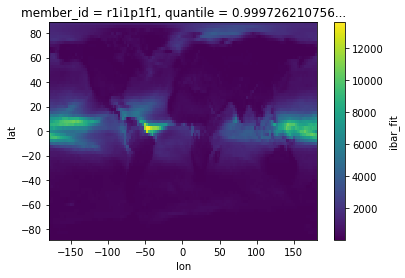

In [16]:
mmle_loaded.results['ibar_fit'].mean('scenario').plot()

In [17]:
results = mmle_loaded.results

In [18]:
results['ibar_fit_frac'] = results['ibar_fit'].mean('scenario')/results['t_fit']
results['m_fit_frac'] = results['m_fit'].mean('scenario')/results['t_fit']
results['s_fit_frac'] = results['s_fit']/results['t_fit']

In [19]:
results

<xarray.Dataset>
Dimensions:        (scenario: 4, time: 130, model: 14, lat: 71, lon: 144)
Coordinates:
  * lat            (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon            (lon) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
    member_id      <U8 'r1i1p1f1'
  * model          (model) <U30 'INM-CM4-8' 'INM-CM5-0' ... 'NorESM2-MM'
    q_values       (model, lat, lon) float64 259.4 259.5 259.6 ... 273.5 273.5
    quantile       float64 0.9997
  * scenario       (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time           (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01
Data variables:
    fit            (scenario, time, model, lat, lon) float64 5.611 ... 313.5
    i_fit          (scenario, model, lat, lon) float64 7.217 7.245 ... 279.0
    ibar_fit       (scenario, lat, lon) float64 10.08 6.557 ... 2.962e+03
    m_fit          (scenario, time, lat, lon) float64 24.01 14.83 ... 7.134e+05
    t_fit          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    s_fit          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ibar_fit_frac  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    m_fit_frac     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    s_fit_frac     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [20]:
time_1 = slice('2005', '2014')
time_2 = slice('2035', '2044')
time_3 = slice('2065', '2075')

data = [
results['ibar_fit_frac'].sel(time=time_1).mean('time'),
results['m_fit_frac'].sel(time=time_1).mean('time'),
results['s_fit_frac'].sel(time=time_1).mean('time'),

results['ibar_fit_frac'].sel(time=time_2).mean('time'),
results['m_fit_frac'].sel(time=time_2).mean('time'),
results['s_fit_frac'].sel(time=time_2).mean('time'),

results['ibar_fit_frac'].sel(time=time_3).mean('time'),
results['m_fit_frac'].sel(time=time_3).mean('time'),
results['s_fit_frac'].sel(time=time_3).mean('time'),

]

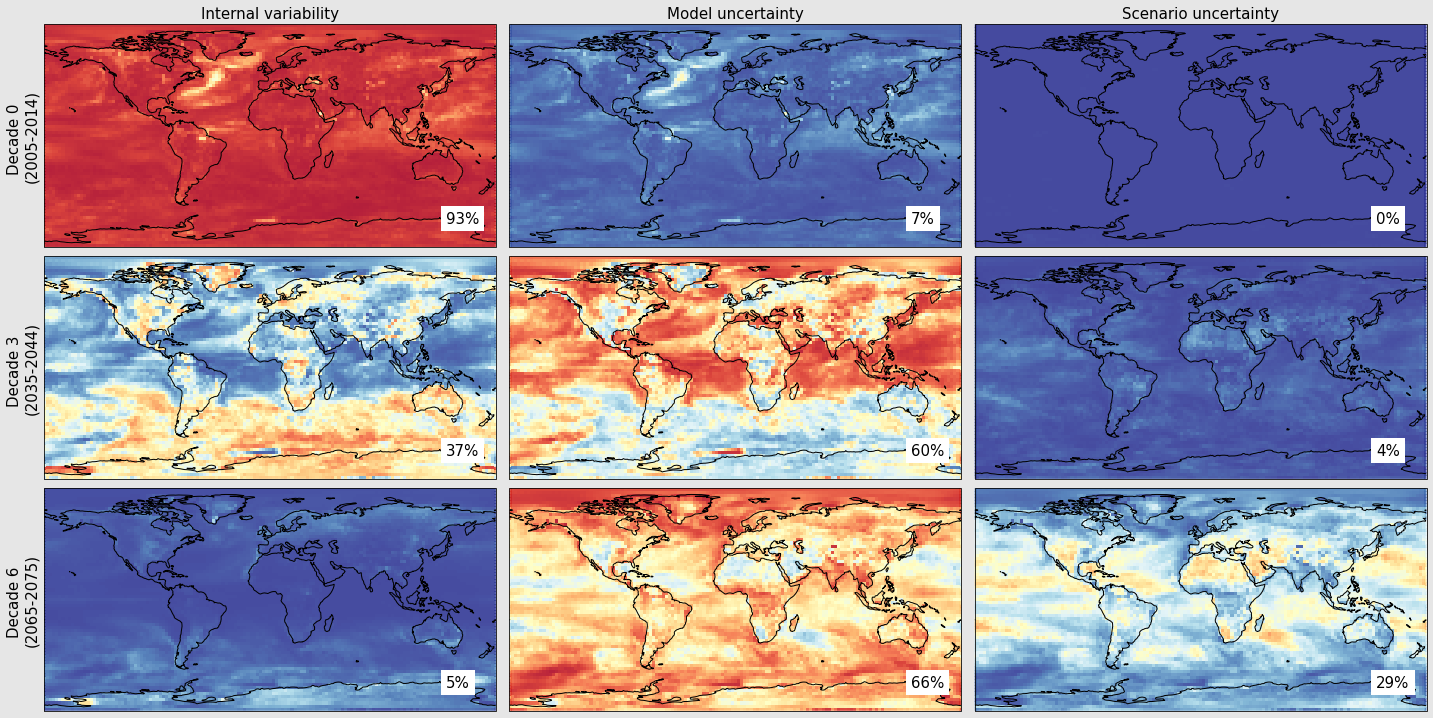

In [53]:
results = mmle_loaded.results
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,10), subplot_kw=dict(projection=ccrs.PlateCarree()))  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))  # To ensure same fontsize, make sure ALL figures have same width!

# orig_map=plt.cm.RdYlBu
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib.

regions = ['USeast','USwest','iceland','europe','australia','tropics']
proj = ccrs.PlateCarree()
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
    None,
    None,
    None,
    None,
    None,
    None,
]
y_labels = [
    'Decade 0 \n(2005-2014)',
    None,
    None,
    'Decade 3 \n(2035-2044)',
    None,
    None,
    'Decade 6 \n(2065-2075)',
    None,
    None,
]
for ax, data_i, title, y_label in zip(axes.ravel(), data, titles, y_labels):
    percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))
#     ax.coastlines(linewidth=2, color='gray')
    ax.coastlines(linewidth=1, color='k')
    data_i.plot(ax=ax, cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=False,
#     add_colorbar=True, cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.7, 'pad': 0.01},
    alpha=0.9   # This makes it a little less jarring
    )
    ax.set_title(title, fontsize=15)
    ax.text(140, -70, f'{percentage}%', fontsize=15,
        bbox={'facecolor': 'white', 
            'alpha': 1, 'pad': 5, 
            'edgecolor' : 'none'})
    if y_label:
        ax.text(-0.01, 0.5, y_label, fontsize=15, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
# plt.subplots_adjust(left=0.05, bottom=0.02, wspace=0, hspace=0.03)
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/cmip_global_fractions.png', dpi=200)
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.

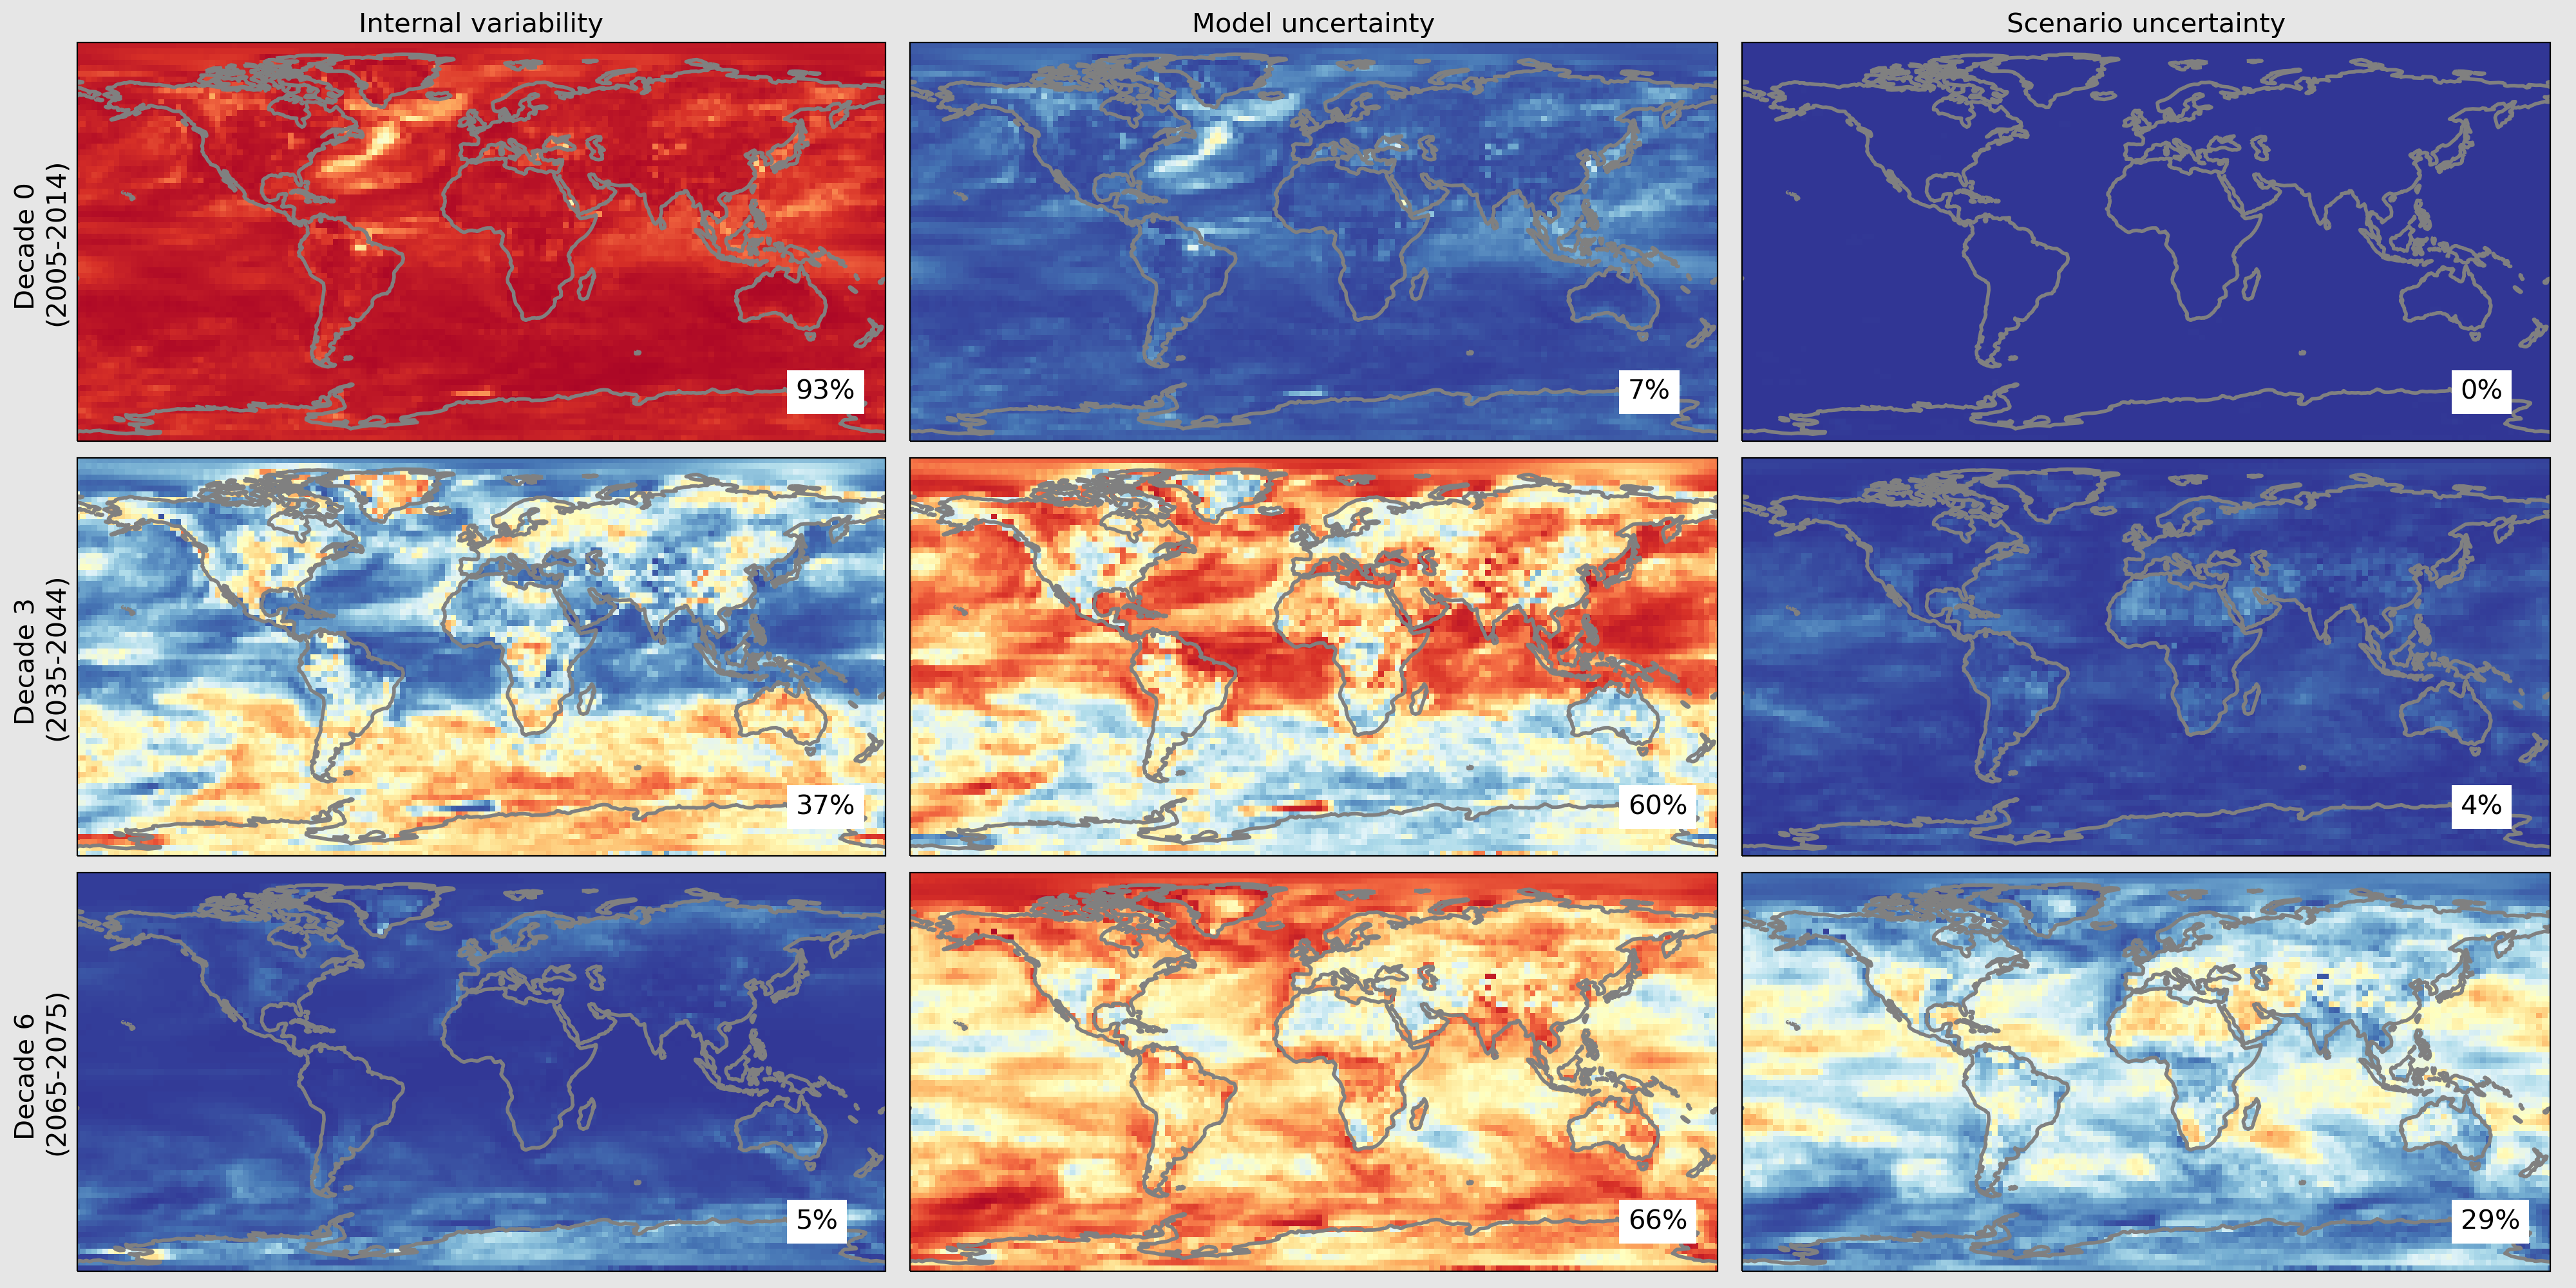

In [42]:
from IPython.display import Image
Image(filename='./plots/cmip_global_fractions.png')   # Don't believe what Jupyter shows you!

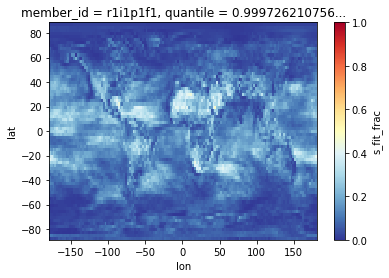

In [56]:
    data_i.plot(cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=True,
    )

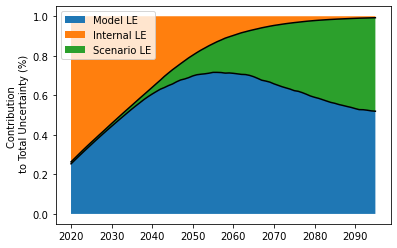

In [57]:
# plot total uncertainty (direct and indirect) 

x=results.sel(time=slice('2020', None)).time.values
y1=results['m_fit_frac'].mean(('lat', 'lon')).sel(time=slice('2020', None))

y2=y1 + results['s_fit_frac'].mean(('lat', 'lon')).sel(time=slice('2020', None))
plt.fill_between(x,0,y1,label='Model LE')
plt.plot(x,y1,color='k')
plt.plot(x,y2,color='k')

plt.fill_between(x,y2,1,label='Internal LE')
plt.fill_between(x,y1,y2,label='Scenario LE')

plt.ylabel('Contribution \n to Total Uncertainty (%)')
plt.legend()
